In [1]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import os

In [2]:
torch.cuda.is_available()
np.random.seed(111)

True

In [3]:
# Enforcing GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [816]:
# Loading file paths
#train_path = 'D:/DataScience/CMAPSS/Data/train_FD00X.txt'
#test_path = 'D:/DataScience/CMAPSS/Data/test_FD00X.txt'
#RUL_path = 'D:/DataScience/CMAPSS/Data/RUL_FD00X.txt'
train_path = f'E:/CMAPSS/data/train_FD00X.txt'
test_path = f'E:/CMAPSS/data/test_FD00X.txt'
RUL_path = f'E:/CMAPSS/data/RUL_FD00X.txt'

labels = ['unit', 'cycles', 'opMode1', 'opMode2', 'opMode3'] + [f'sensor{i}' for i in range(1, 22)]  # for 22 sensors

In [817]:
# Function to load data and drop the columns specified by cols_to_drop, and add an RUL column for each unit
def load_data(filepath, rul=False):
    data = []
    # Creating lists which hold dataframes for each test trajectory
    if not rul:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    names=labels, delimiter='\s+',
                                    dtype=np.float32))
        return data
    else:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    delimiter='\s+', header=None,
                                    dtype=np.float32))

        return data  # a list


def prepare_data(train_data: pd.DataFrame):
    # Drops redundant columns and adds an RUL column for training
    
    ### TRAINING DATAFRAMES ###

    rul = pd.DataFrame(train_data.groupby('unit')['cycles'].max()).reset_index()
    rul.columns = ['unit', 'max']

    train_data = train_data.merge(rul, on=['unit'], how='left')

    train_data['RUL'] = train_data['max'] - train_data['cycles']
    train_data.drop('max', axis=1, inplace=True)

    return train_data

In [818]:
# Initialising data
train_data, test_data, RUL_data = load_data(train_path), load_data(test_path), load_data(RUL_path, True)

# Adding RUL columns to the training dataframes dataframe
for i in range(len(train_data)):
    train_data[i] = prepare_data(train_data[i])

# Trajectories FD001 and FD003 both have redundant readings which can be dropped as they are constant or rarely change. FD004 and FD002 both have a redundant sensor 16.
cols_to_drop = ['opMode3', 'sensor1', 'sensor5',
                'sensor6', 'sensor10', 'sensor16',
                'sensor18', 'sensor19', 'sensor17']

train_data[0].drop(columns=cols_to_drop, inplace=True)
train_data[2].drop(columns=cols_to_drop, inplace=True)
test_data[0].drop(columns=cols_to_drop, inplace=True)
test_data[2].drop(columns=cols_to_drop, inplace=True)

train_data[1].drop(columns=['sensor16'], inplace=True)
train_data[3].drop(columns=['sensor16'], inplace=True)


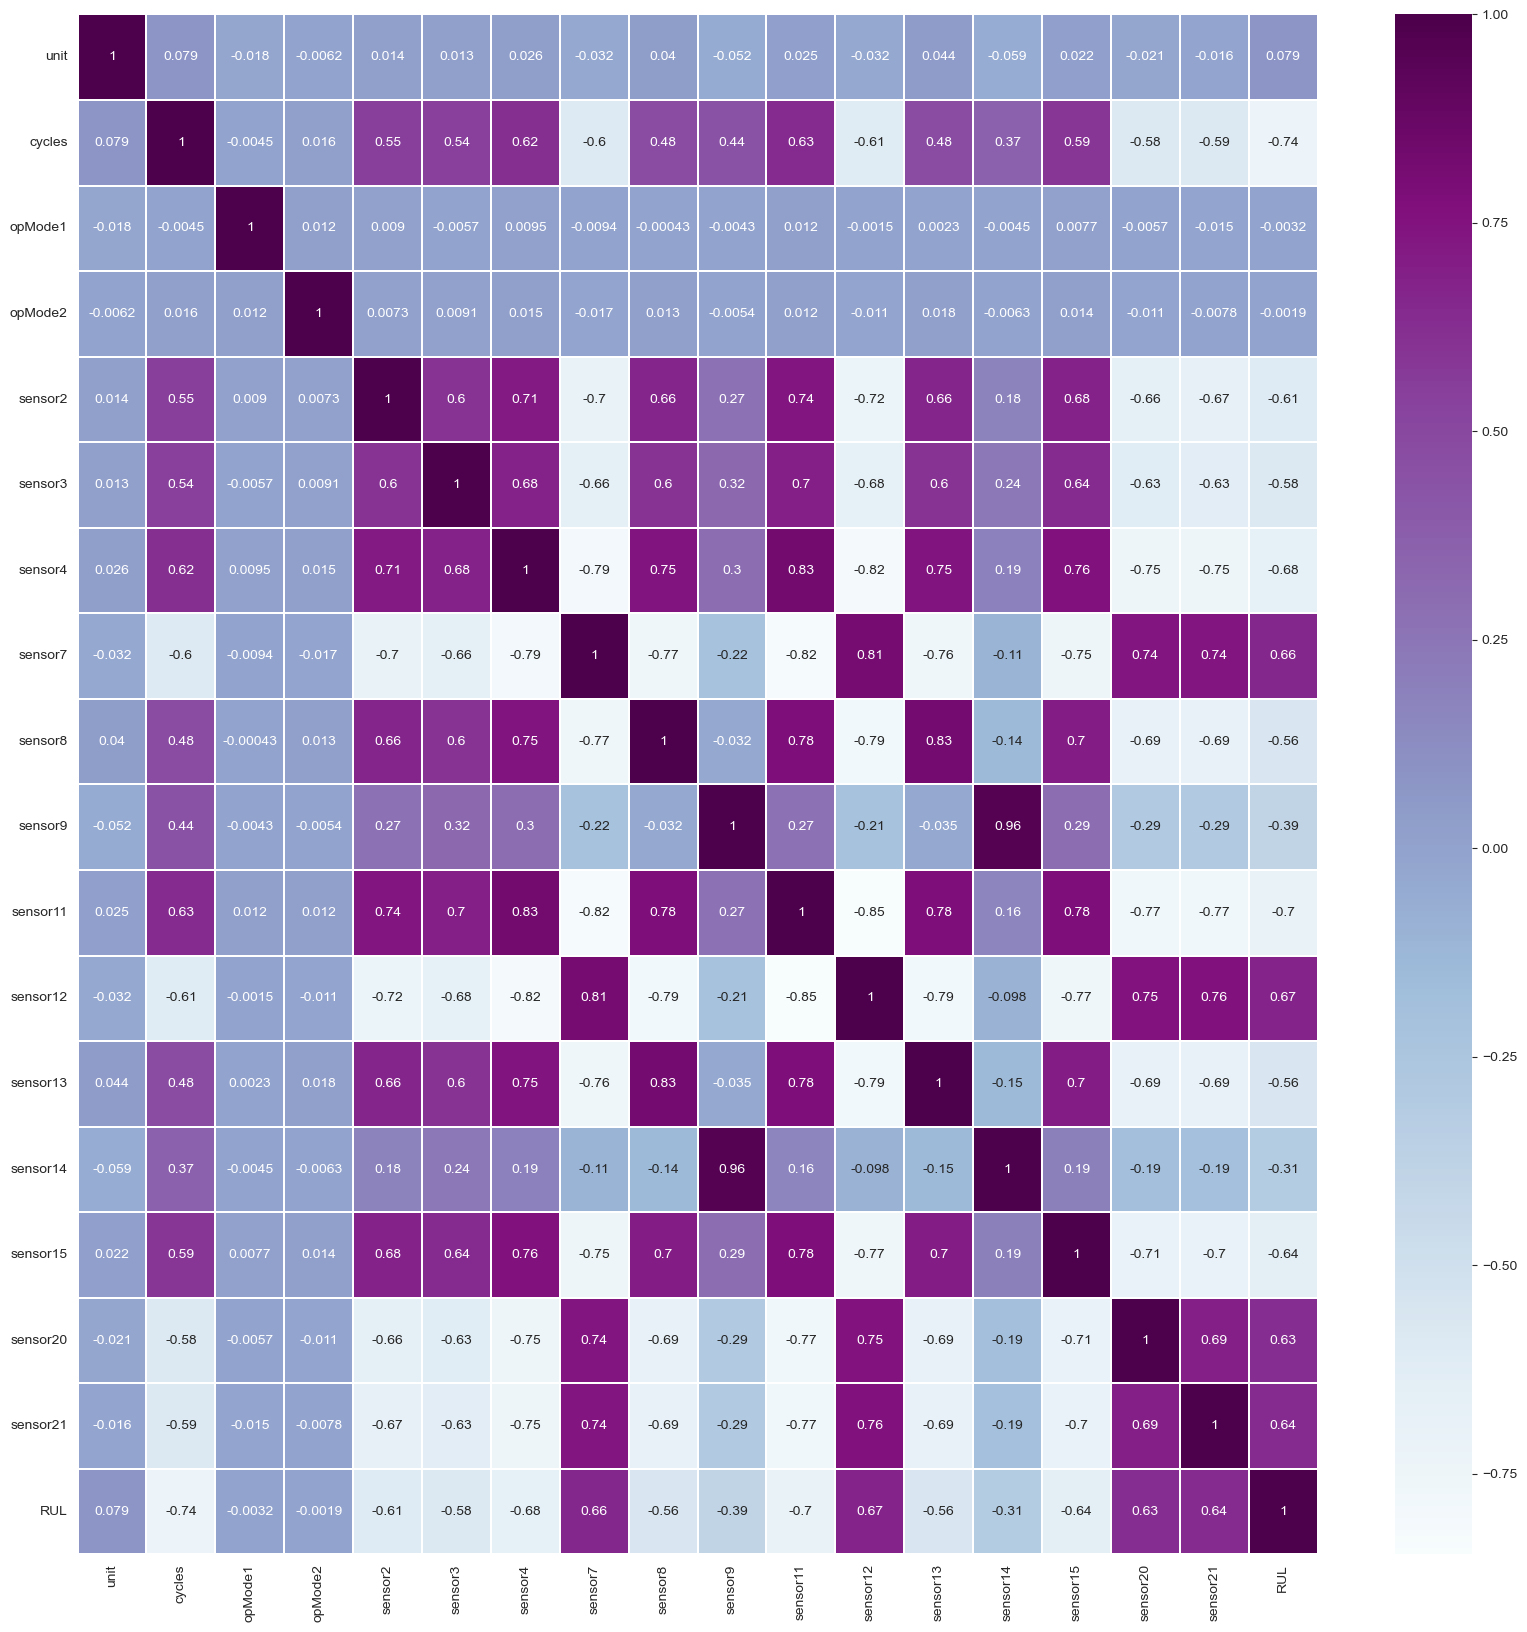

In [819]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

In [820]:
# Removing properties with weak correlation and high inter-correlation
# sensor 14 and has aa very high correlation with sensor 9, we can remove sensor 14 to reduce multicollinearity
train_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
train_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)

In [821]:
# Min-max scaling the data, except [cycles, RUL]
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data[0].iloc[:, 2:-1] = scaler.fit_transform(train_data[0].iloc[:, 2:-1])
test_data[0].iloc[:, 2:] = scaler.transform(test_data[0].iloc[:, 2:])

train_data[2].iloc[:, 2:-1] = scaler.fit_transform(train_data[2].iloc[:, 2:-1])
test_data[2].iloc[:, 2:] = scaler.transform(test_data[2].iloc[:, 2:])

In [822]:
# Creating a training sequence
def create_training_sequence(df, seq_length, seq_cols):
    
    """function to prepare training data into (samples, time steps, features)
    df = training dataframe
    seq_length = look-back period
    seq_cols = feature columns"""

    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]

    lstm_array = []

    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

def create_target_sequence(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length - 1:num_elements + 1]


def create_training_batch(df, seq_length, columns):
    """Since the test data is stopped some arbitrary time before failure,
       the number of engine cycles won't necessarily be longer than a given window length,
       so we generate testing sequences which meet the sequence_length 
       """
    x = np.concatenate(
        list(list(create_training_sequence(df[df['unit'] == i], seq_length, columns)) for i in df['unit'].unique()))
    y = np.concatenate(
        list(list(create_target_sequence(df[df['unit'] == i], seq_length, 'RUL')) for i in df['unit'].unique()))
    return x, y


In [823]:
FD_columns = [[column for column in df if column != 'RUL'] for df in train_data]

In [1038]:
sequence_length = 35
trajectory = 0  # see readme file
batch_size = 230

In [825]:
FD001_train = train_data[trajectory]
FD001_test = test_data[trajectory]
FD001_truth = RUL_data[trajectory]

In [1039]:
a, b = create_training_batch(FD001_train, sequence_length, FD_columns[trajectory])

In [1040]:
feature_count = a.shape[2]
out_dim = 1  # output dimension (1 RUL value)

In [1041]:
x_train, x_val, y_train, y_val = train_test_split(a, b, test_size=0.1, random_state=42)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

In [1042]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [830]:
# Using the ground truth labels to create an RUL column in the test data
rul = pd.DataFrame(FD001_test.groupby('unit')['cycles'].max()).reset_index()
rul.columns = ['unit', 'max']
FD001_truth.columns = ['rulTruth']
FD001_truth['unit'] = np.arange(1, len(rul) + 1, 1)  # 100 units
FD001_truth['startLife'] = rul['max'] + FD001_truth['rulTruth']  # 
FD001_truth.drop(columns=['rulTruth'], inplace=True)

In [831]:
FD001_test = FD001_test.merge(FD001_truth, on=['unit'], how='left')
FD001_test['RUL'] = FD001_test['startLife'] - FD001_test['cycles']
FD001_test.drop('startLife', axis=1, inplace=True)

In [1043]:
test_cols = list(FD001_test.columns[:-1])
x_test = create_training_sequence(FD001_test, sequence_length, test_cols)
x_test_tensor = torch.tensor(x_test).float().to(device)

# Model performance functions


In [1044]:
def evaluation_metrics(ground_truth, prediction):
    print(f"Mean squared error: {mean_squared_error(ground_truth, prediction)}")
    print(f"Root mean squared error: {root_mean_squared_error(ground_truth, prediction)}")
    print(f"R2 score: {r2_score(ground_truth, prediction)}")
    print(f"Mean absolute error: {mean_absolute_error(ground_truth, prediction)}")
    return None


def loss_graphs(model):
    # expects a tuple of training and validation losses
    e = range(1, len(model[0]) + 1)  # the lists in the tuple are of equal length, can be model[1]
    plt.figure(figsize=(10,5))
    plt.plot(e, model[0], 'b', label='Training loss')
    plt.plot(e, model[1], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

# Random forests

In [1014]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=90, n_jobs=-1, max_features=13, max_depth=10, random_state=42)

# Reshaping 3D tensors for random forest compatibility
x_train_reshaped = x_train.reshape(x_train.shape[0], sequence_length * feature_count)
x_val_reshaped = x_val.reshape(x_val.shape[0], sequence_length * feature_count)
x_test_reshaped = x_test.reshape(x_test.shape[0], sequence_length * feature_count)
start_idx = 2000
end_idx = 2900

truncated_ground_truth = FD001_test['RUL'][(sequence_length-1):].reset_index(drop=True)
truncated_subset = truncated_ground_truth[start_idx:end_idx].reset_index(drop=True)

rf.fit(x_train_reshaped, y_train)
rf_val_predictions = rf.predict(x_val_reshaped)
print('Validation metrics:')
evaluation_metrics(y_val, rf_val_predictions)

print('\nTest data metrics:')
rf_test_predictions = rf.predict(x_test_reshaped)
evaluation_metrics(truncated_ground_truth, rf_test_predictions)


Validation metrics:
Mean squared error: 461.8599869778375
Root mean squared error: 21.49092801574277
R2 score: 0.8574632690161617
Mean absolute error: 15.784857360893204

Test data metrics:
Mean squared error: 3556.4914000633657
Root mean squared error: 59.636326178457416
R2 score: -0.018841164545899902
Mean absolute error: 44.372009068517094


In [1015]:
from sklearn.model_selection import GridSearchCV

estim = RandomForestRegressor()

# performing grid search for RF regressor
param_grid = {
    'n_estimators': [70, 90, 120],
    'max_depth': [7, 8, 9],
    'max_features': [8, 9, 10]
}

grid = GridSearchCV(estim, param_grid, n_jobs=-1, cv=3)
grid.fit(x_train_reshaped, y_train)
print(grid.best_score_, grid.best_params_)


0.7986178574523514 {'max_depth': 9, 'max_features': 10, 'n_estimators': 70}


In [1018]:
# Predict and train using optimised model
rf_final = RandomForestRegressor(n_estimators=70, max_depth=9, max_features=10, random_state=42)
rf_final.fit(x_train_reshaped, y_train)

print('Train data metrics:')
final_train_predictions = rf_final.predict(x_train_reshaped)
evaluation_metrics(y_train, final_train_predictions)

print('\nValidation data metrics:')
final_val_predictions = rf_final.predict(x_val_reshaped)
evaluation_metrics(y_val, final_val_predictions)

print('\nTest data metrics:')
final_test_predictions = rf_final.predict(x_test_reshaped)
evaluation_metrics(truncated_ground_truth, final_test_predictions)


Train data metrics:
Mean squared error: 434.4165090257846
Root mean squared error: 20.8426607952484
R2 score: 0.8682027773429024
Mean absolute error: 15.16100469183875

Validation data metrics:
Mean squared error: 600.0275849825524
Root mean squared error: 24.495460497458552
R2 score: 0.8148227322674647
Mean absolute error: 17.767953365150213

Test data metrics:
Mean squared error: 3574.202366505929
Root mean squared error: 59.78463319705097
R2 score: -0.02391489020576043
Mean absolute error: 44.1697244365938


array([135.29638744, 127.84164122, 130.21719003, ...,  34.19081709,
        33.20208568,  28.12659101])

# SVM

In [1030]:
from sklearn.svm import SVR
svr_regressor = SVR(kernel='rbf')
svr_regressor.fit(x_train_reshaped, y_train) 

SVR()

In [1034]:
y_svr_train = svr_regressor.predict(x_train_reshaped)
y_svr_test = svr_regressor.predict(x_test_reshaped)
y_svr_val = svr_regressor.predict(x_val_reshaped)

In [1037]:
print('Training data performance: ')
evaluation_metrics(y_train, y_svr_train)
print('\nTest data performance: ')
evaluation_metrics(truncated_ground_truth, y_svr_test)
print('\nValidation data performance: ')
evaluation_metrics(y_val, y_svr_val)

Training data performance: 
Mean squared error: 1885.2703747413414
Root mean squared error: 43.41970030690379
R2 score: 0.42802956566766603
Mean absolute error: 31.237636689456526

Test data performance: 
Mean squared error: 4870.164457529559
Root mean squared error: 69.78656358877086
R2 score: -0.39517391419843184
Mean absolute error: 52.709999570676615

Validation data performance: 
Mean squared error: 1809.56155090867
Root mean squared error: 42.53894158190434
R2 score: 0.44154290206364366
Mean absolute error: 30.833743434968344


# Model Creation

We use an LSTM model to capture the long-term dependencies in the time series data.

In [1045]:
# Defining LSTM class
class DamagePropagationLSTM(nn.Module):
    def __init__(self, feature_count, out_dim):
        super(DamagePropagationLSTM, self).__init__()
        # Stacked convolutional block
        #self.cnn = nn.Sequential(
            #nn.Conv1d(in_channels=feature_count, out_channels=64, kernel_size=3, padding='same'),
            #nn.ReLU(),
            #nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding='same'),
            #nn.ReLU(),
            #nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
        #)
        
        self.lstm1 = nn.LSTM(input_size=feature_count, hidden_size=100, batch_first=True)
        #self.batch_norm = nn.BatchNorm1d(num_features=256) 
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=100, hidden_size=50, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(in_features=50, out_features=out_dim)
        self.activation2 = nn.ReLU()

    def forward(self, x):
        #x = self.conv1(x.transpose(1, 2)).transpose(1, 2)
        #x = self.maxpool1d(x)
        #x = self.flatten(x)
        #x = self.dense1(x)
       #x = self.activation1(x)
        
        #x = self.cnn(x.transpose(1, 2)).transpose(1, 2)
        x, _ = self.lstm1(x)
        #x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout1(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.dropout2(hn[-1])
        x = self.dense2(x)
        x = self.activation2(x)
        return x
       
   

In [1046]:
# training function
def train_model(model, criterion, optimizer, 
                scheduler, train_loader, val_loader, 
                num_epochs=60, patience=20, destination='unnamed_model.pt'):
    best_loss = float('inf')
    patience_counter = 0
    print("Model initialised successfully. Beginning training on {dev}...".format(dev=torch.cuda.get_device_name(0)))
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data).to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * data.size(0)

        epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data).to(device)
                loss = criterion(outputs, targets)
            
                epoch_val_loss += loss.item() * data.size(0)
                
        
        
        epoch_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        scheduler.step(epoch_val_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), destination)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping!')
            break
    return train_losses, val_losses



In [1047]:
Model = DamagePropagationLSTM(feature_count, out_dim).to(device)

In [1048]:
# Loss criterion
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(Model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

In [1049]:
root_path = os.getcwd()
model_directory = 'models'
if not os.path.isdir(model_directory):
    os.mkdir(model_directory)
model_number = 22
model_path = root_path + os.path.join(f'\{model_directory}', f'lstm_{model_number}.pt')
model_path

'E:\\ML\\NeurIPS2024\\pmh\\models\\lstm_22.pt'

In [1050]:
epochs = 70
model1 = train_model(Model, criterion, optimizer, scheduler,
                     train_loader, val_loader, num_epochs=epochs, 
                     patience=15, destination=model_path)

Model initialised successfully. Beginning training on NVIDIA GeForce RTX 3070...
Epoch 1/70, Training Loss: 10586.6648, Validation Loss: 10178.7799
Epoch 2/70, Training Loss: 9684.6705, Validation Loss: 9512.7188
Epoch 3/70, Training Loss: 9093.5070, Validation Loss: 8965.9886
Epoch 4/70, Training Loss: 8583.6124, Validation Loss: 8478.9840
Epoch 5/70, Training Loss: 8126.1579, Validation Loss: 8032.5989
Epoch 6/70, Training Loss: 7695.3606, Validation Loss: 7614.3408
Epoch 7/70, Training Loss: 7299.1266, Validation Loss: 7218.1301
Epoch 8/70, Training Loss: 6907.2941, Validation Loss: 6813.1111
Epoch 9/70, Training Loss: 6499.6287, Validation Loss: 6452.9176
Epoch 10/70, Training Loss: 6116.7896, Validation Loss: 6027.2556
Epoch 11/70, Training Loss: 5758.2753, Validation Loss: 5705.2785
Epoch 12/70, Training Loss: 5433.3204, Validation Loss: 5355.7116
Epoch 13/70, Training Loss: 5120.1349, Validation Loss: 5048.7725
Epoch 14/70, Training Loss: 4813.2983, Validation Loss: 4761.8479
Ep

In [955]:
ModelTest = DamagePropagationLSTM(feature_count, out_dim).to(device)
ModelTest.load_state_dict(torch.load(model_path))
ModelTest.eval()

DamagePropagationLSTM(
  (lstm1): LSTM(14, 100, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=50, out_features=1, bias=True)
  (activation2): LeakyReLU(negative_slope=0.01)
)

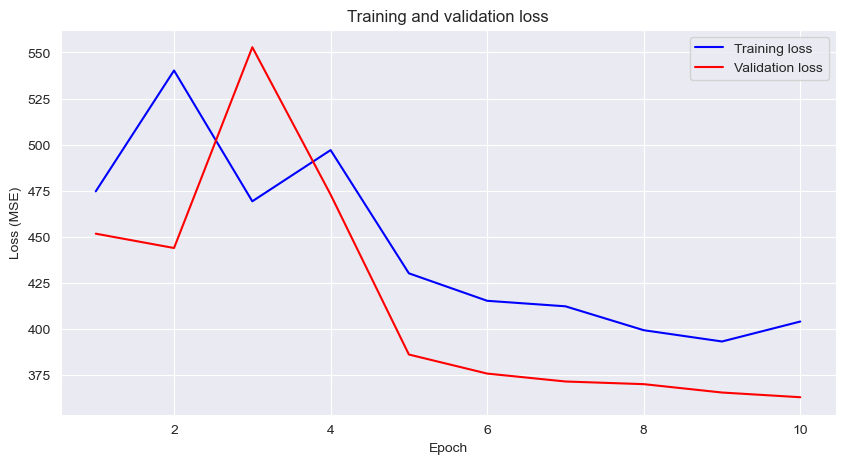

In [957]:
loss_graphs(model1)


### Model evaluation on validation data

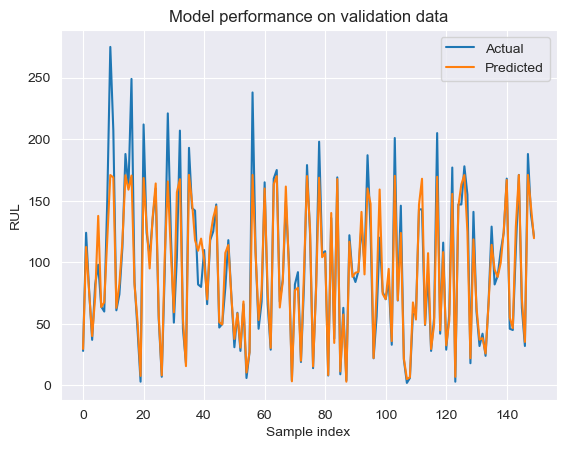

In [958]:
# Preparing data for training evaluation
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)

with torch.no_grad():
    y_train_pred = ModelTest(x_train_tensor)
    
y_train_pred = y_train_pred.cpu()
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).cpu()

# Plotting
plt.plot(y_train[0:150], label='Actual')
plt.plot(y_train_pred[0:150], label='Predicted')
plt.title('Model performance on validation data')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.legend()
plt.show()

In [959]:
# Validation data test metrics
evaluation_metrics(y_train, y_train_pred)

Mean squared error: 325.1573181152344
Root mean squared error: 18.032119750976562
R2 score: 0.9013919882196839
Mean absolute error: 10.127676010131836


# Preparing test data

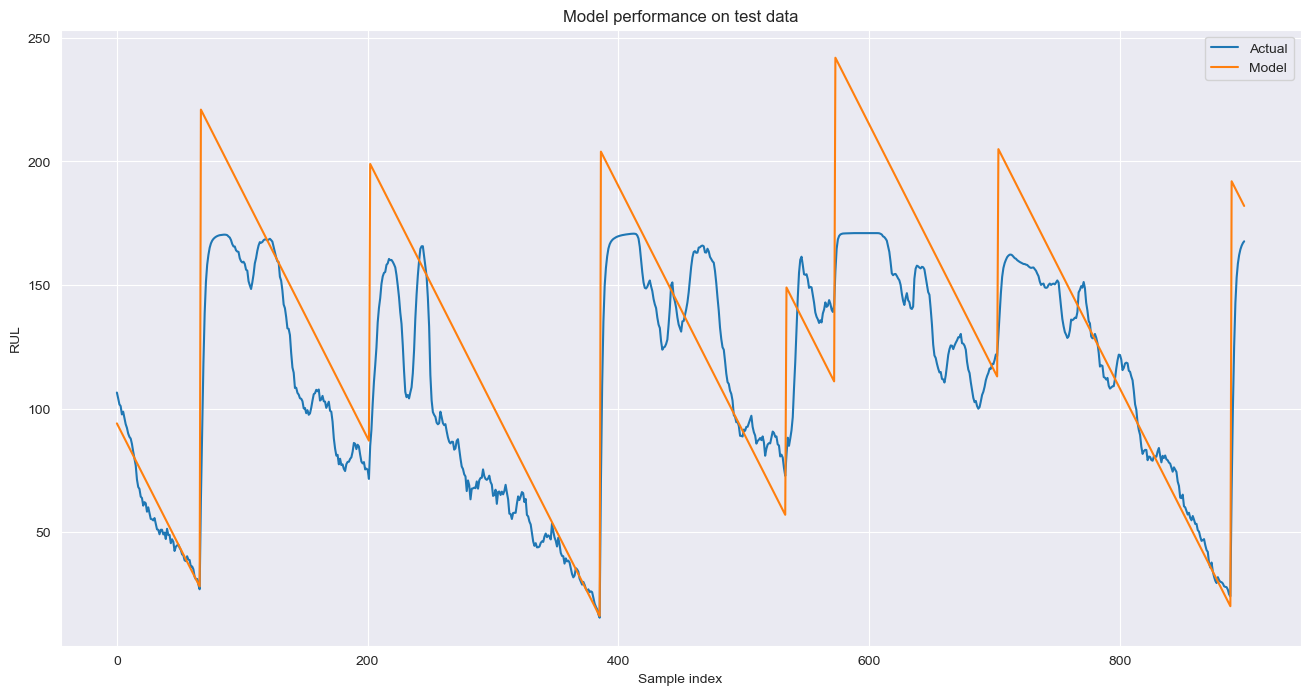

In [962]:
ModelTest.eval()
with torch.no_grad():
    y_test_pred = ModelTest(x_test_tensor)
    
y_test_pred = torch.Tensor.cpu(y_test_pred)
start_idx = 2000
end_idx = 2900
truncated_ground_truth = FD001_test['RUL'][(sequence_length-1):].reset_index(drop=True)
truncated_subset = truncated_ground_truth[start_idx:end_idx].reset_index(drop=True)

plt.figure(figsize=(16,8))
plt.plot(y_test_pred[start_idx:end_idx], label='Actual')
plt.plot(truncated_subset, label='Model')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.title("Model performance on test data")
plt.legend()
plt.show()


In [963]:
# Test data evaluation
evaluation_metrics(truncated_ground_truth, y_test_pred)
print(ModelTest)
print(f"Sequence length: {sequence_length}\nBatch size: {batch_size}")

Mean squared error: 2212.366455078125
Root mean squared error: 47.03580093383789
R2 score: 0.3662152625917259
Mean absolute error: 33.99071502685547
DamagePropagationLSTM(
  (lstm1): LSTM(14, 100, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=50, out_features=1, bias=True)
  (activation2): LeakyReLU(negative_slope=0.01)
)
Sequence length: 50
Batch size: 250


Exploring the uses of dropout layers in recurrent architectures and how to optimise them.
[1] https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7333848&tag=1
Convolutional layer adjustment
[2] https://arxiv.org/pdf/1603.07285v1